Description:  This script produces Figure 2 (location of OKLMA sensors and KTLX radar)
which are the primary source of observational data used for analysis in this study

In [1]:
import math
import os
from functools import partial

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as geod
import cartopy.feature as cf
from descartes import PolygonPatch

import geopandas

import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
import pyproj
import shapely.affinity
from shapely.geometry import MultiPolygon, Point, Polygon
from shapely.ops import transform as sh_transform

import may19_2013_obs_analysis.parsed_functions as pf
from may19_2013_obs_analysis.coordinateSystems import TangentPlaneCartesianSystem, GeographicSystem, MapProjection
from may19_2013_obs_analysis.utils import transformed_coords

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2

### Source detection efficiency plots

In [2]:
c0 = 3.0e8 # m/s
dt_rms = 42.e-9 # seconds ; chosen from the best looking chi square fit from xlma gui 

sq = np.load('../../../LMAsimulation/source_quantiles',fix_imports=True, encoding='latin1',allow_pickle=True) # in Watts 
fde = 100-np.load('../../../LMAsimulation/fde.csv',fix_imports=True, encoding='latin1',allow_pickle=True) # Corresponding flash DE

In [3]:
# network csv file with one or multiple networks
stations = pd.read_csv('../../../LMAsimulation/network_full.csv') 

In [4]:
# Remove stations FAA (F_m), Olustee (O), and Zombie (Z) as those were not active on May 19

all_data = stations.set_index('network')
oklma_data = all_data[all_data[' station'].isin([' C_m', ' D ', ' E ',
                                                ' G',' H ',' I ',' M ',' N ',
                                                ' W_m',' Y ',' A ',' P ',' U ',
                                                ' B ',' R '])]

aves = np.array(oklma_data)[:,:-1].astype('float')

In [5]:
center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])
mapp = MapProjection
projl = MapProjection(projection='laea', lat_0=center[0], lon_0=center[1])

alt, lat, lon  = aves[:,:3].T

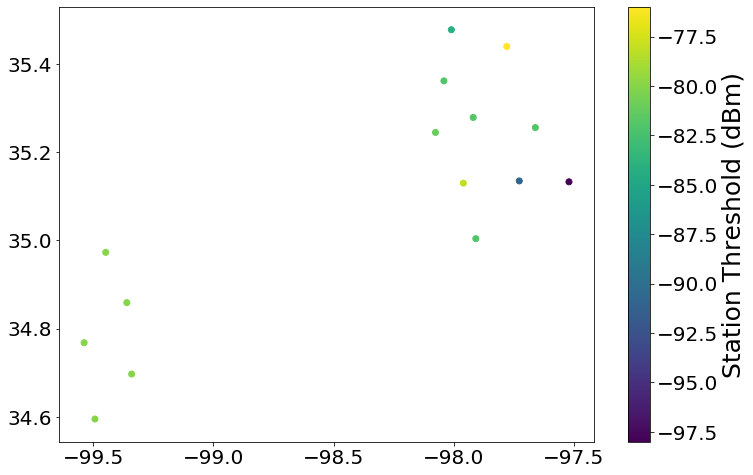

In [6]:
plt.scatter(lon, lat, c=aves[:,3])
plt.colorbar(label='Station Threshold (dBm)')
plt.show()

### Inclusive function for detection calculations

* Make sure the input array of station information matches the given dimensions
* Will check for solution in the line of sight for each station within 300 km of the network at the chosen altitude (default = 7 km) and grid spacing (default = 5 km)
* Minimum number of stations required to participate in solutions can be set (default = 6)

In [7]:
# %matplotlib qt5
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import patches

In [8]:
latp, lonp, sde, fde_a, minp = pf.quick_method(
                 # input array must be in N x (lat, lon, alt, threshold) 
                 np.array([aves[:,1],aves[:,2],aves[:,0],aves[:,3]]).transpose(), 
                 sq, fde, 
                 xint=5000, # Grid spacing
                 altitude=7000, # Altitude of grid MSL
                 station_requirement=6, # Minimum number of stations required to trigger
                )

In [9]:
plt.rcParams["axes.labelpad"] = 20

In [10]:
# load location data for all sensors belonging to OKLMA
# The data is prepared and saved in the 'lma_df.txt' file

# load data in a pandas dataframe
df = pd.read_csv("../data/interim/lma_df.txt", sep="\t")

# we need only station name, latitude, and longitude information from the dataframe
df = df[df.columns[1:4]]
df.columns = ["stn_name", "lat", "lon"]

# Next, we assign an active (A) or non-active (NA) status to each station location
# We get this info from the .dat.gz file (this one is for time 2140 UTC on May 19, 2013)

df["status"] = "A"  # assign A to every station

# Next, we replace the column values in status column only
# for those stations which were inactive during that period
def replace_vals(row):
    if (
        (row["stn_name"] == "FAA")
        or (  # These three stations were not working at all
            row["stn_name"] == "Olustee"
        )
        or (row["stn_name"] == "Zombie")
    ):
        row["status"] = "NA"

    elif (
        (row["stn_name"] == "Dutton")
        or (  # These stations within central OKLMA had really low detection efficiency
            row["stn_name"] == "Chickasha N"
        )
        or (row["stn_name"] == "Minco SE")
    ):
        row["status"] = "LOW"
    return row


df = df.apply(replace_vals, axis=1)

In [11]:
# create a geopandas dataframe and use it to plot station locations
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))

In [12]:
# Next, we want to calculate the centroids of central and western LMA array separately
# to be able to show their combined coverage area

# first we isolate central OK array
central_ok_df = df.iloc[:11]
central_ok_coords_df = central_ok_df[central_ok_df.columns[1:]]

# next is west OK array
west_ok_df = df.iloc[11:]
west_ok_coords_df = west_ok_df[west_ok_df.columns[1:]]

In [13]:
def centroid_geolocation(coords_df):
    """
    Retrieve the mean location from a group of latlon coordinate pairs
    
    Input:
    
    coords_df: Dataframe with two columns, one each for latitude and longitude for a set of points
    
    Returns:
    mean_location of the cluster of points specified in the dataframe
    """
    x = 0.0
    y = 0.0
    z = 0.0

    for i, coord in coords_df.iterrows():
        latitude = math.radians(coord.lat)
        longitude = math.radians(coord.lon)

        x += math.cos(latitude) * math.cos(longitude)
        y += math.cos(latitude) * math.sin(longitude)
        z += math.sin(latitude)

    total = len(coords_df)

    x = x / total
    y = y / total
    z = z / total

    central_longitude = math.atan2(y, x)
    central_square_root = math.sqrt(x * x + y * y)
    central_latitude = math.atan2(z, central_square_root)

    mean_location = {
        "latitude": math.degrees(central_latitude),
        "longitude": math.degrees(central_longitude),
    }

    return mean_location

In [14]:
# find the latitude and longitude of central OKLMA centroid
ctrl_lma_lat = centroid_geolocation(central_ok_coords_df)["latitude"]
ctrl_lma_lon = centroid_geolocation(central_ok_coords_df)["longitude"]

# find the latitude and longitude of western OKLMA centroid
west_lma_lat = centroid_geolocation(west_ok_coords_df)["latitude"]
west_lma_lon = centroid_geolocation(west_ok_coords_df)["longitude"]

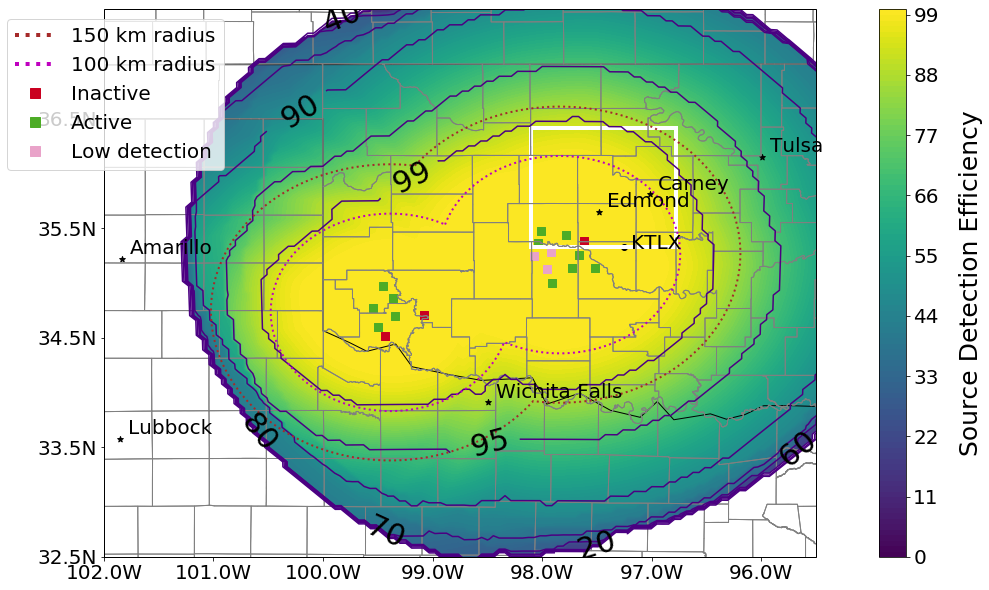

In [83]:
proj = ccrs.PlateCarree()
poly_ctrl_lma1 = Polygon(transformed_coords(proj,lat=ctrl_lma_lat,lon=ctrl_lma_lon,radius=100e3))
poly_ctrl_lma2 = Polygon(transformed_coords(proj,lat=ctrl_lma_lat,lon=ctrl_lma_lon,radius=150e3))

poly_west_lma1 = Polygon(transformed_coords(proj,lat=west_lma_lat,lon=west_lma_lon,radius=100e3))
poly_west_lma2 = Polygon(transformed_coords(proj,lat=west_lma_lat,lon=west_lma_lon,radius=150e3))


fig = plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonp, latp, np.ma.masked_where(sde<1, sde), 
             levels=np.arange(0,101,1), cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(label='Source Detection Efficiency')

CS = plt.contour(lonp,latp,fde_a, colors='indigo',levels=(20,40,60,70,80,85,90,95,99))
plt.clabel(CS, inline=1, fontsize=30,fmt='%3.0f',colors='k',
           rightside_up=True)

ax.add_feature(lakes, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.coastlines()

ax.set_xticks(np.arange(-102,-95,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(32.5,37.5,1), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(number_format='.1f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


# read US county shapefile to be overlaid on projected map
reader = shpreader.Reader("/path/to/county_shapefile.shp")
counties = list(reader.geometries())

# idea to plot counties from # idea from https://stackoverflow.com/questions/51106763/county-boarders-in-cartopy
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
ax.add_feature(COUNTIES, facecolor="none", edgecolor="gray")

g1 = gdf[gdf.status == "NA"].plot(ax=ax, color="#ca0020", marker="s", markersize=50,label="Inactive")
g2 = gdf[gdf.status == "A"].plot(ax=ax, color="#4dac26", marker="s", markersize=50,label="Active")
g3 = gdf[gdf.status == "LOW"].plot(ax=ax, color="#e9a3c9", marker="s", markersize=50, label="Low detection")


legend_elements = [Line2D([0], [0], color='brown', lw=4, label='100 km',linestyle=':'),
                   Line2D([0], [0], color='m', lw=4, label='150 km',linestyle=':'),
                   Line2D([0], [0], color='#ca0020', marker='s',markersize=5, linewidth=0,label='Inactive'),
                   Line2D([0], [0], color='#4dac26', marker='s',markersize=5, linewidth=0,label='Active'),
                   Line2D([0], [0], color='#e9a3c9', marker='s',markersize=5, linewidth=0,label='Low detection')
                  ]

# And manually add the labels here
ax.legend((legend_elements[0],legend_elements[1],legend_elements[2],legend_elements[3],legend_elements[4]),
           ('150 km radius','100 km radius','Inactive','Active','Low detection'),
           bbox_to_anchor=(-0.15, 0.5, 0.5, 0.5), prop={'size': 20})

ax.add_patch(patches.Rectangle(xy=[-98.10241203793976,35.33028567327827], width=1.3266096132191763,
                               height=1.0832816316229952,alpha=1, 
                               edgecolor='w',facecolor="None",
                               linewidth=4,
                               transform=ccrs.PlateCarree())
             )

cities = ["Tulsa", "Edmond", "Carney", "Wichita Falls", "Lubbock", "Amarillo"]
city_lons = [-95.9928, -97.4781, -97.0128, -98.4934, -101.8552, -101.8313]
city_lats = [36.1540, 35.6528, 35.8084, 33.9137, 33.5779, 35.2220]

city_names_dict = {"loc%d" % i: v for i, v in enumerate(cities)}
city_lons_dict = {"lon%d" % i: v for i, v in enumerate(city_lons)}
city_lats_dict = {"lat%d" % i: v for i, v in enumerate(city_lats)}

lons_final = []
lats_final = []
cities_final = []

for key, value in city_lons_dict.items():
    lons_final.append(value)
# print(lons_final)
for key, value in city_lats_dict.items():
    lats_final.append(value)
for key, value in city_names_dict.items():
    cities_final.append(value)
        
lon_koun = -97.46333
lat_koun = 35.23611
lon_ktlx = -97.2557
lat_ktlx = 35.3331

ax.scatter(lons_final, lats_final, transform=ccrs.PlateCarree(), marker="*", c="k")
for i in range(len(cities_final)):
    ax.text(
        lons_final[i] + 0.07,
        lats_final[i] + 0.04,
        cities_final[i],
        transform=ccrs.PlateCarree(),
        fontsize=20,
    )

ax.scatter(lon_ktlx, lat_ktlx, transform=ccrs.PlateCarree(), marker="o", c="k")
ax.text(
    lon_ktlx + 0.07,
    lat_ktlx - 0.02,
    "KTLX",
    transform=ccrs.PlateCarree(),
    fontsize=20,
)

# add polygons for 100 and 150 km range for central OKLMA
combined_area100 = PolygonPatch(poly_ctrl_lma1.union(poly_west_lma1), fc='None', 
                                ec='m', alpha=1, zorder=3, linestyle=':',linewidth=2)

# add polygons for 100 and 150 km range for west OKLMA
combined_area150 = PolygonPatch(poly_ctrl_lma2.union(poly_west_lma2), fc='None', 
                                ec='brown', alpha=1, zorder=3, linestyle=':',linewidth=2)

ax.add_patch(combined_area100)
ax.add_patch(combined_area150)

ax.set_extent([-102, -95.5, 32.5, 37.5])

plt.tight_layout()
plt.show()

### Using output from MC simulation
This for the simulation output with points located at only 7 km altitude

In [85]:
# network csv file with one or multiple networks
stations = pd.read_csv('../../../LMAsimulation/network_full.csv') 

# Remove stations FAA (F_m), Olustee (O), and Zombie (Z) as those were not active on May 19

all_data = stations.set_index('network')
oklma_data = all_data[all_data[' station'].isin([' C_m', ' D ', ' E ',
                                                ' G',' H ',' I ',' M ',' N ',
                                                ' W_m',' Y ',' A ',' P ',' U ',
                                                ' B ',' R '])]

aves = np.array(oklma_data)[:,:-1].astype('float')

In [86]:
center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])
mapp = MapProjection
projl = MapProjection(projection='laea', lat_0=center[0], lon_0=center[1])

alt, lat, lon  = aves[:,:3].T
stations_ecef  = np.array(geo.toECEF(lon, lat, alt)).T
stations_local = tanp.toLocal(stations_ecef.T).T

center_ecef = np.array(geo.toECEF(center[1],center[0],center[2]))
ordered_threshs = aves[:,-1]

In [87]:
xmin, xmax, xint = -200001, 199999, 5000
ymin, ymax, yint = -200001, 199999, 5000
alts = np.arange(500,20500,500.)
# alts = np.array([7000])

initial_points = np.array(np.meshgrid(np.arange(xmin,xmax+xint,xint),
                                      np.arange(ymin,ymax+yint,yint), alts))

In [88]:
iterations = 100
misses = np.load('../data/processed/detection_efficiency/misses_full_grid.dat',allow_pickle=True)

xs  = 1000./np.arange(10,1000,1.) # Theoretical source detection efficiency that corresponds with fde
fde = 100-np.load('../../../LMAsimulation/fde.csv',fix_imports=True, encoding='latin1',allow_pickle=True) # Corresponding flash DE
sde = 100-np.mean(misses[0,:,:,:], axis=2)*100./iterations # Calculated source detection efficiency
fde_a = np.empty_like(sde)

selects = sde == 100. # Put into the next lowest or equivalent flash DE from given source DE
fde_a[selects] = 100.
for i in range(len(xs)-1):
    selects = (sde >= xs[1+i]) & (sde < xs[i])
    fde_a[selects] = fde[i]

# Find center of 95% SOURCE detection efficiency
goods = (100-np.mean(misses[0,:,:,:], axis=2)*100./iterations)>95. 
de_centery = np.mean(initial_points[1,:,:,0][goods])
de_centerx = np.mean(initial_points[0,:,:,0][goods])

In [89]:
# alts = np.array([7000])
initial_points = np.array(np.meshgrid(np.arange(xmin,xmax+xint,xint),
                                      np.arange(ymin,ymax+xint,xint), alts))

x,y,z=initial_points.reshape((3,int(np.size(initial_points)/3)))
points2 = np.array(projl.toECEF(x,y,z)).T

xp,yp,zp = points2.T
lonp,latp,zp = geo.fromECEF(xp,yp,zp)
# latp = latp.reshape(np.shape(initial_points)[1],np.shape(initial_points)[2])
latp = latp.reshape(np.shape(initial_points)[1],np.shape(initial_points)[2],np.shape(initial_points)[3])

# lonp = lonp.reshape(np.shape(initial_points)[1],np.shape(initial_points)[2])
lonp = lonp.reshape(np.shape(initial_points)[1],np.shape(initial_points)[2],np.shape(initial_points)[3])

#for 95% DE center
depts = np.array(projl.toECEF((de_centerx),(de_centery),alts)).T
xde,yde,zde = depts.T
londe,latde,zp = geo.fromECEF(xde,yde,zde)

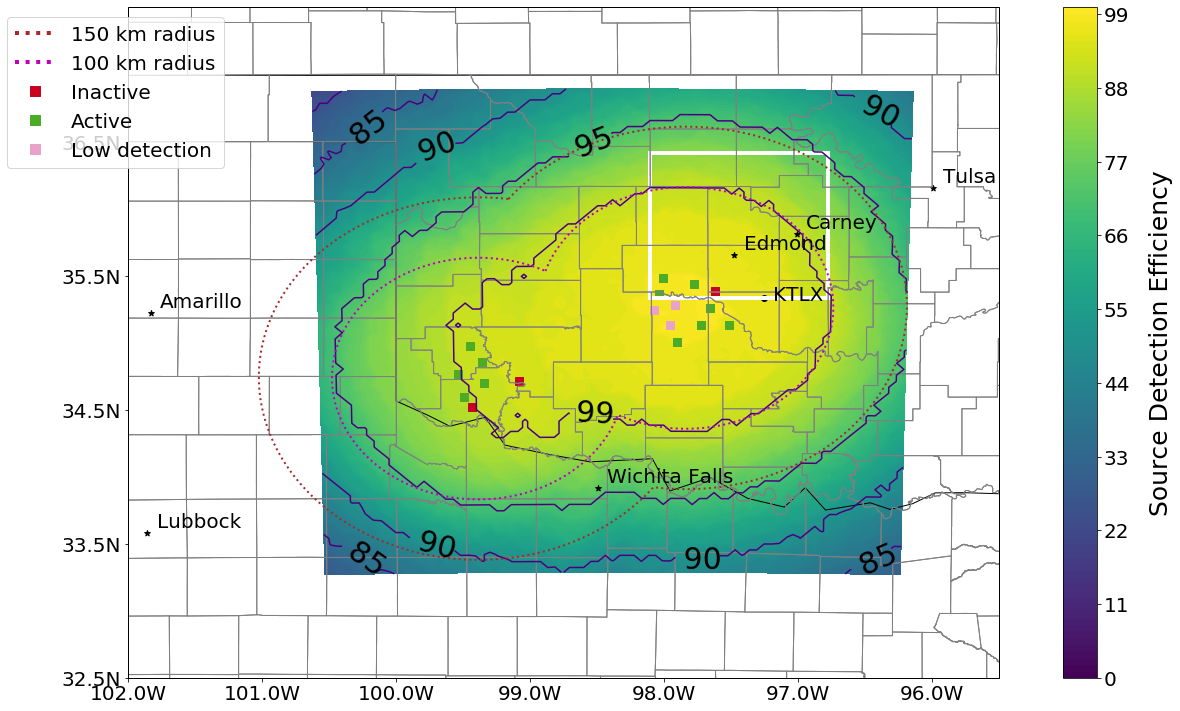

In [90]:
proj = ccrs.PlateCarree()
poly_ctrl_lma1 = Polygon(transformed_coords(proj,lat=ctrl_lma_lat,lon=ctrl_lma_lon,radius=100e3))
poly_ctrl_lma2 = Polygon(transformed_coords(proj,lat=ctrl_lma_lat,lon=ctrl_lma_lon,radius=150e3))

poly_west_lma1 = Polygon(transformed_coords(proj,lat=west_lma_lat,lon=west_lma_lon,radius=100e3))
poly_west_lma2 = Polygon(transformed_coords(proj,lat=west_lma_lat,lon=west_lma_lon,radius=150e3))

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonp[:,:,0], latp[:,:,0], np.ma.masked_where(sde<1, sde), 
             levels=np.arange(0,101,1), cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(label='Source Detection Efficiency')

plt.scatter(oklma_data[' lon'],oklma_data[' lat'],transform=ccrs.PlateCarree(),marker='s',color='k')
CS = plt.contour(lonp[:,:,0],latp[:,:,0],fde_a, colors='indigo',levels=(20,40,60,70,80,85,90,95,99))
plt.clabel(CS, inline=1, fontsize=30,fmt='%3.0f',colors='k',
           rightside_up=True)
# CS.collections[-1].set_linewidth(3)  

# plt.scatter(londe,latde, color='r',transform=ccrs.PlateCarree())

# ax.set_extent((-103, -90, 30, 40))

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='110m',
    facecolor='none')
ax.add_feature(lakes, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.coastlines()

ax.set_xticks(np.arange(-102,-95,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(32.5,37.5,1), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(number_format='.1f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


# read US county shapefile to be overlaid on projected map
reader = shpreader.Reader("/path/to/county_shapefile.shp")
counties = list(reader.geometries())

# idea to plot counties from # idea from https://stackoverflow.com/questions/51106763/county-boarders-in-cartopy
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

# ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(COUNTIES, facecolor="none", edgecolor="gray")
ax.set_extent([-102, -95.5, 32.5, 37.5])

g1 = gdf[gdf.status == "NA"].plot(ax=ax, color="#ca0020", marker="s", markersize=50,label="Inactive")
g2 = gdf[gdf.status == "A"].plot(ax=ax, color="#4dac26", marker="s", markersize=50,label="Active")
g3 = gdf[gdf.status == "LOW"].plot(ax=ax, color="#e9a3c9", marker="s", markersize=50, label="Low detection")

# Now make a dummy object that looks as similar as possible
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='brown', lw=4, label='100 km',linestyle=':'),
                   Line2D([0], [0], color='m', lw=4, label='150 km',linestyle=':'),
                   Line2D([0], [0], color='#ca0020', marker='s',markersize=5, linewidth=0,label='Inactive'),
                   Line2D([0], [0], color='#4dac26', marker='s',markersize=5, linewidth=0,label='Active'),
                   Line2D([0], [0], color='#e9a3c9', marker='s',markersize=5, linewidth=0,label='Low detection')
                  ]

# And manually add the labels here
ax.legend((legend_elements[0],legend_elements[1],legend_elements[2],legend_elements[3],legend_elements[4]),
           ('150 km radius','100 km radius','Inactive','Active','Low detection'),
           bbox_to_anchor=(-0.15, 0.5, 0.5, 0.5), prop={'size': 20})

ax.add_patch(patches.Rectangle(xy=[-98.10241203793976,35.33028567327827], width=1.3266096132191763,
                               height=1.0832816316229952,alpha=1, 
                               edgecolor='w',facecolor="None",
                               linewidth=4,
                               transform=ccrs.PlateCarree())
             )

      
cities = ["Tulsa", "Edmond", "Carney", "Wichita Falls", "Lubbock", "Amarillo"]
city_lons = [-95.9928, -97.4781, -97.0128, -98.4934, -101.8552, -101.8313]
city_lats = [36.1540, 35.6528, 35.8084, 33.9137, 33.5779, 35.2220]

city_names_dict = {"loc%d" % i: v for i, v in enumerate(cities)}
city_lons_dict = {"lon%d" % i: v for i, v in enumerate(city_lons)}
city_lats_dict = {"lat%d" % i: v for i, v in enumerate(city_lats)}

lons_final = []
lats_final = []
cities_final = []

for key, value in city_lons_dict.items():
    lons_final.append(value)
# print(lons_final)
for key, value in city_lats_dict.items():
    lats_final.append(value)
for key, value in city_names_dict.items():
    cities_final.append(value)
        
lon_koun = -97.46333
lat_koun = 35.23611
lon_ktlx = -97.2557
lat_ktlx = 35.3331

ax.scatter(lons_final, lats_final, transform=ccrs.PlateCarree(), marker="*", c="k")
for i in range(len(cities_final)):
    ax.text(
        lons_final[i] + 0.07,
        lats_final[i] + 0.04,
        cities_final[i],
        transform=ccrs.PlateCarree(),
        fontsize=20,
    )

ax.scatter(lon_ktlx, lat_ktlx, transform=ccrs.PlateCarree(), marker="o", c="k")
ax.text(
    lon_ktlx + 0.07,
    lat_ktlx - 0.02,
    "KTLX",
    transform=ccrs.PlateCarree(),
    fontsize=20,
)

# add polygons for 100 and 150 km range for central OKLMA
combined_area100 = PolygonPatch(poly_ctrl_lma1.union(poly_west_lma1), fc='None', 
                                ec='m', alpha=1, zorder=3, linestyle=':',linewidth=2)

# add polygons for 100 and 150 km range for west OKLMA
combined_area150 = PolygonPatch(poly_ctrl_lma2.union(poly_west_lma2), fc='None', 
                                ec='brown', alpha=1, zorder=3, linestyle=':',linewidth=2)

ax.add_patch(combined_area100)
ax.add_patch(combined_area150)

ax.set_extent([-102, -95.5, 32.5, 37.5])

plt.tight_layout()
plt.show()

### Mean altitude error

In [97]:
def mapped_plot(data,projl,vmin,vmax,cmap,stations,
                xmin,xmax,xint,ymin,ymax,yint,location):
    
    """Make plots in map projection with km color scales, requires input 
       array, lower color scale limit, higher color scale limit, color scale, 
       station location overlay, and array x-,y- min, max and interval, the 
       location of the array center (in lat and lon). Output plot also 
       contains 100, 200 km range rings
    """
    import cartopy.crs as ccrs
    
    domain = (xmax-xint/2.)
    proj = ccrs.LambertAzimuthalEqualArea(central_longitude=location[1], central_latitude=location[0])
    
    poly_ctrl_lma1 = Polygon(transformed_coords(proj,lat=ctrl_lma_lat,lon=ctrl_lma_lon,radius=100e3))
    poly_ctrl_lma2 = Polygon(transformed_coords(proj,lat=ctrl_lma_lat,lon=ctrl_lma_lon,radius=150e3))

    poly_west_lma1 = Polygon(transformed_coords(proj,lat=west_lma_lat,lon=west_lma_lon,radius=100e3))
    poly_west_lma2 = Polygon(transformed_coords(proj,lat=west_lma_lat,lon=west_lma_lon,radius=150e3))

    tmp_geog = GeographicSystem()
    
    tmp_ecx,tmp_ecy,tmp_ecz = tmp_geog.toECEF(location[1],location[0],0)
    center_x,center_y,center_z = projl.fromECEF(tmp_ecx,tmp_ecy,tmp_ecz)
    
    plt.figure(figsize=(18,10))
    
    ax = plt.axes(projection=proj)
    s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint),
               np.arange(ymin-yint/2.,ymax+3*yint/2.,yint),
               data,cmap = cmap,transform=proj)
    
    s.set_clim(vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.scatter(stations[:,0], stations[:,1], color='k')

#     circle=plt.Circle((center_x,center_y),100000,color='k',fill=False)
#     fig = plt.gcf()
#     fig.gca().add_artist(circle)
#     circle=plt.Circle((center_x,center_y),150000,color='k',fill=False)
#     fig = plt.gcf()
#     fig.gca().add_artist(circle)
                
    states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
    lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='110m',
        facecolor='none')
    ax.add_feature(lakes, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
    ax.coastlines()
    
#     ax.set_xticks(np.arange(-102,-95,1), crs=ccrs.PlateCarree())
#     ax.set_yticks(np.arange(32.5,37.5,1), crs=ccrs.PlateCarree())

#     lon_formatter = LongitudeFormatter(number_format='.1f',
#                                        degree_symbol='',
#                                        dateline_direction_label=True)
#     lat_formatter = LatitudeFormatter(number_format='.1f',
#                                       degree_symbol='')
#     ax.xaxis.set_major_formatter(lon_formatter)
#     ax.yaxis.set_major_formatter(lat_formatter)


    # read US county shapefile to be overlaid on projected map
    reader = shpreader.Reader("/path/to/county_shapefile.shp")

    counties = list(reader.geometries())

    # idea to plot counties from # idea from https://stackoverflow.com/questions/51106763/county-boarders-in-cartopy
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())    
    ax.add_feature(COUNTIES, facecolor="none", edgecolor="gray")
    
    # add polygons for 100 and 150 km range for central OKLMA
    combined_area100 = PolygonPatch(poly_ctrl_lma1.union(poly_west_lma1), fc='None', 
                                    ec='m', alpha=1, zorder=3, linestyle=':',linewidth=2)

    # add polygons for 100 and 150 km range for west OKLMA
    combined_area150 = PolygonPatch(poly_ctrl_lma2.union(poly_west_lma2), fc='None', 
                                    ec='brown', alpha=1, zorder=3, linestyle=':',linewidth=2)

    ax.add_patch(combined_area100)
    ax.add_patch(combined_area150)


    ax.set_extent([-102, -95.5, 32.5, 37.5])

In [98]:
means = np.load('../data/processed/detection_efficiency/means_full_grid.dat',allow_pickle=True)
stds = np.load('../data/processed/detection_efficiency/stds_full_grid.dat',allow_pickle=True)
misses = np.load('../data/processed/detection_efficiency/misses_full_grid.dat',allow_pickle=True)

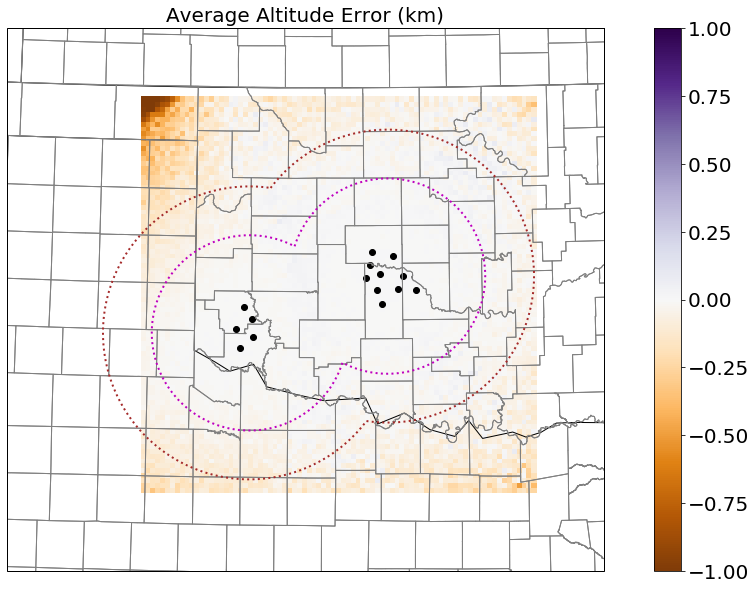

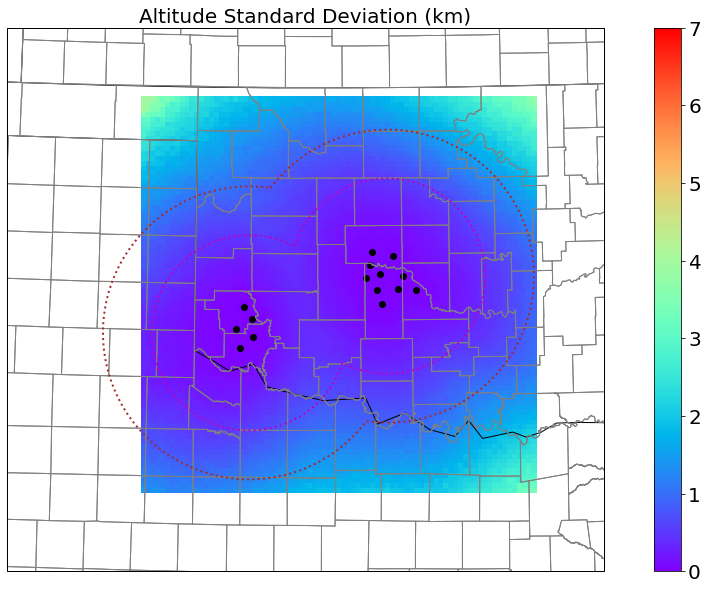

In [99]:
mapped_plot(np.mean(means[2,:,:,:],axis=2)/1000.,projl,-1,1,'PuOr',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Average Altitude Error (km)',fontsize=20)
plt.show()

mapped_plot(np.mean(stds[2,:,:,:],axis=2)/1000.,projl,0,7,'rainbow',stations_local,xmin,xmax,xint,ymin,ymax,yint,center)
plt.title('Altitude Standard Deviation (km)',fontsize=20)
plt.show()